In [44]:
import os, glob
import numpy as np
import numpy.random as rand
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import offsetbox as obox
from mpl_toolkits.mplot3d import Axes3D
from sklearn import model_selection as slms, preprocessing as spre
from skimage import measure as meas, feature as feat
import cv2 as cv
from tqdm import tnrange, tqdm_notebook as tqdm
from jupyterthemes import jtplot

In [81]:
jtplot.reset()
plt.style.use("bmh")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [3]:
traindir = 'D:/Kenneth/Documents/VIP/Datasets/ripe_classes/'

In [200]:
class MCPerceptron:
    def __init__(self,
                 n_samples,
                 n_features,
                 epochs,
                 activation='step',
                 loss='sse',
                 lr=0.01,
                 eps=1e-6,
                 weight_initializer='random_uniform',
                 use_bias=False,
                 bias_initializer='ones'):
        rand.seed(401)
        self.n_samples = n_samples
        self.n_features = n_features
        self.epochs = epochs
        self.activation = activation
        self.loss = loss
        self.lr = lr
        self.eps = eps
        self.weight_initializer = weight_initializer
        self.use_bias = use_bias
        self.bias_initializer = bias_initializer
        
        if self.weight_initializer == 'random_uniform':
            if use_bias:
                self.W = rand.random(self.n_features + 1)
            else:
                self.W = rand.random(self.n_features)
        elif self.weight_initializer == 'random_normal':
            if use_bias:
                self.W = rand.normal((0, 1, (self.n_features + 1)))
            else:
                self.W = rand.normal((0, 1, (self.n_features)))
        else:
            raise NotImplementedError
            
        if self.use_bias:
            if self.bias_initializer == 'ones':
                self.b = np.ones(self.n_samples)
            else:
                raise NotImplementedError

        if self.activation == 'step':
            self.g = lambda a: 1 if a >= 0 else -1
        elif self.activation == 'sigmoid':
            self.g = lambda a: 1/(1 + np.exp(-a))
        elif self.activation == 'softmax':
            self.g = lambda a: np.exp(a)/np.sum(np.exp(a))
        else:
            raise NotImplementedError
            
        if self.loss == 'sse':
            self.l = lambda y_true, y_pred: (y_true - y_pred)**2
        else:
            raise NotImplementedError

    def train(self, x, y):
        self.graph_res = []
        x = np.column_stack((self.b, x))
        for count in tnrange(self.epochs, desc='Epoch'):
            res = 0
            for i in range(self.n_samples):
                a = x[i].T.dot(self.W)
                z = self.g(a)
                dW = self.lr * (y[i] - z) * x[i]
                self.W += dW
                res += self.l(z, y[i])
            res /= self.n_samples
            self.graph_res.append(res)
            if res < self.eps:
                break
        self.last_epoch = count + 1
                 
    def predict(self, X, y=None, metrics=None):
        if self.use_bias:
            z = np.zeros(X.shape[0] + 1)
            X = np.column_stack((np.ones(len(X)), X))
        else:
            z = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            a = X[i].dot(self.W)
            z[i] = self.g(a)
        if metrics is not None and 'acc' in metrics and y is not None:
            acc = 0.
            for i in range(len(y)):
                if np.round(z[i]).astype(int) == y[i]:
                    acc += 1
            acc /= len(y)
            self.metrics = dict({'acc': acc})
        self.preds = z
        return z
                
    def get_weights(self):
        return self.W
    
    def get_biases(self):
        return self.x.T[0]

    def get_line_params(self):
        W = self.W
        A, B, C = W[1], W[2], -W[0]
        m = -A/B
        b = C/B
        return m, b
    
    def save_weights(self, filename):
        np.save(filename, self.W)
        
    def load_weights(self, filename):
        self.W = np.load(filename)


def getChannelMeans(x):
    return np.array([np.mean(x[:,:,i]) for i in range(3)])

def getFeatureVectors(X):
    for i,x in enumerate(X):
        if i == 0:
            features = np.zeros((len(X), 3))
        img = cv.imread(x)
        img = cv.cvtColor(img, cv.COLOR_BGR2Lab)/255
        features[i] = getChannelMeans(img)
    return features

In [201]:
unripes = []
ripes = []

files = glob.glob(traindir + 'Green/*.jpg')
for i,f in enumerate(files):
    if i == 0:
        unripes = np.zeros((len(files)), '<U256')
    unripes[i] = f
    
files = glob.glob(traindir + 'Overripen/*.jpg')
for i,f in enumerate(files):
    if i == 0:
        ripes = np.zeros((len(files)), '<U256')
    ripes[i] = f

In [202]:
unripes = unripes[:len(ripes)]
banana = np.concatenate((unripes, ripes))
classes = np.concatenate((np.tile(0, len(unripes)), np.tile(1, len(ripes))))
x_train, x_test, y_train, y_test = slms.train_test_split(banana, classes,
                                                         test_size=0.2, 
                                                         shuffle=True)

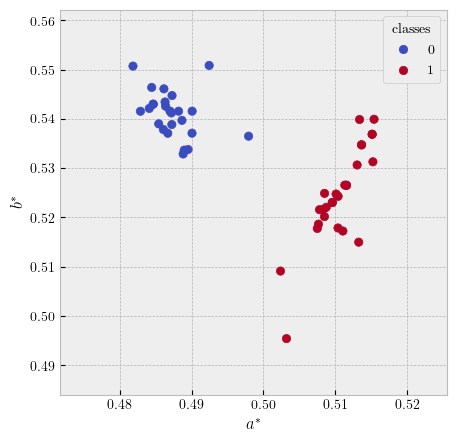

In [203]:
features = getFeatureVectors(x_train)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
scatter = ax.scatter(features[:,1], features[:,2], 
                     marker='o', c=y_train, cmap='coolwarm')
legend = ax.legend(*scatter.legend_elements(), 
                   title='classes')
ax.add_artist(legend)
ax.set_xlabel('$a^*$')
ax.set_ylabel('$b^*$')
# plt.savefig('Lab_extract.png', dpi=300, bbox_inches='tight')
plt.show()

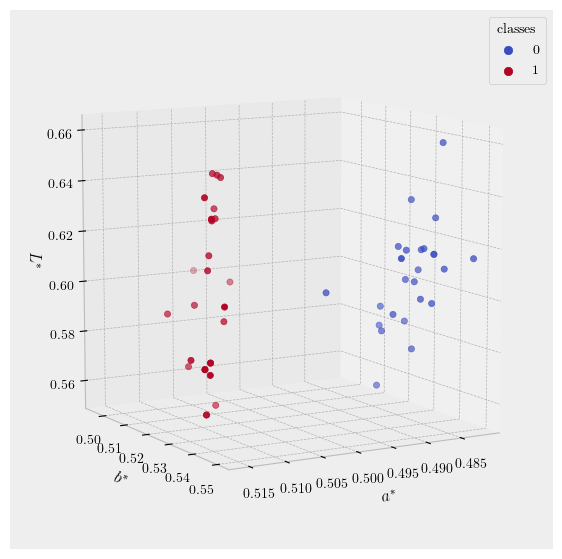

In [204]:
features = getFeatureVectors(x_train)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features[:,1], features[:,2], features[:,0], 
               'o', c=y_train, cmap='coolwarm')
legend = ax.legend(*scatter.legend_elements(), 
                   title='classes')
ax.add_artist(legend)
ax.set_xlabel('$a^*$')
ax.set_ylabel('$b^*$')
ax.set_zlabel('$L^*$')
ax.view_init(elev=10, azim=60)
# plt.savefig('Lab_extract.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
mcp = MCPerceptron(n_samples=len(x_train),
                   n_features=2,
                   epochs=int(1e6),
                   activation='sigmoid',
                   loss='sse',
                   lr=0.1,
                   eps=0.01,
                   use_bias=True)
mcp.train(features[:,1:], y_train)
mcp.save_weights('lab.npy')

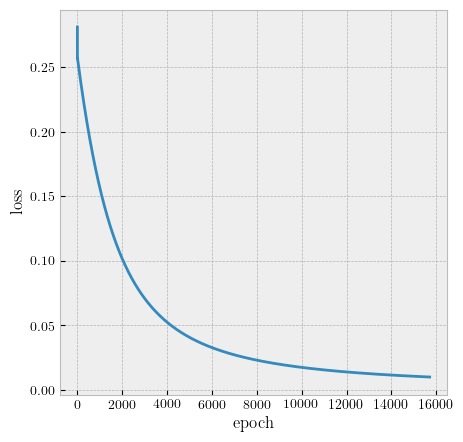

In [12]:
plt.plot(mcp.graph_res)
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.savefig('Lab_loss.png', dpi=300, bbox_inches='tight')
plt.show()

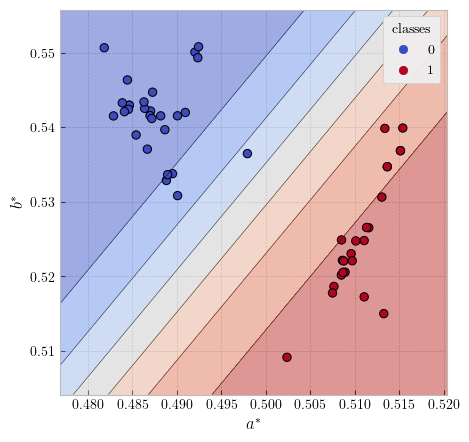

In [13]:
xmin, xmax = np.min(features[:,1])-5e-3, np.max(features[:,1])+5e-3
ymin, ymax = np.min(features[:,2])-5e-3, np.max(features[:,2])+5e-3
db_x = np.linspace(xmin, xmax, 100)
db_y = np.linspace(ymin, ymax, 100)
xx, yy = np.meshgrid(db_x, db_y)
Z = mcp.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:-1].reshape(xx.shape)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.5)
ax.contour(xx, yy, Z, colors='k', linewidths=0.3)
ax.scatter(features[:,1], features[:,2], 
           marker='o', linewidths=0.75, edgecolors='k',
           c=y_train, cmap='coolwarm')

legend = ax.legend(*scatter.legend_elements(), 
                   title='classes')
ax.add_artist(legend)
ax.set_xlabel('$a^*$')
ax.set_ylabel('$b^*$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# plt.savefig('Lab_decision.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
features = getFeatureVectors(x_test)
mcp.predict(features[:,1:], y_test, metrics=['acc'])
mcp.metrics['acc']

1.0

In [15]:
files = glob.glob(traindir + 'Midripen/*.jpg')
for i,f in enumerate(files):
    if i == 0:
        midripes = np.zeros((len(files)), '<U256')
    midripes[i] = f

In [16]:
features = getFeatureVectors(midripes)
mcp.predict(features[:,1:])

array([0.40180758, 0.80698473, 0.18349945, 0.45263981, 0.68794184,
       0.33500798, 0.97042878, 0.84529666, 0.78900698, 0.69262517,
       0.46559044, 0.82364609, 0.30589555, 0.98160278, 0.96367195,
       0.92564102, 0.95602426, 0.98343447, 0.3134663 , 0.41858851,
       0.27010725, 0.35245576, 0.15962494, 0.31866079, 0.14444007,
       0.24197435, 0.24616508, 0.24616508, 0.287034  , 0.2001214 ,
       0.18182585, 0.26245851, 0.17958314, 0.22209952, 0.34046528,
       0.32384282, 0.1644962 , 0.30025206, 0.21654006, 0.28662801,
       0.31023271, 0.30076334, 0.20852873, 0.577876  , 0.43021093,
       0.28249079, 0.19218925, 0.32058735, 0.67569462, 0.26003796,
       0.2304434 , 0.35904021, 0.36826215, 0.13871741, 0.38592406,
       0.19502071, 0.28483814, 0.31970144, 0.39640106, 0.24577951,
       0.68521809, 0.52400853, 0.26166178, 0.48102808, 0.36104579,
       0.4952037 , 0.47964176, 0.70727638, 0.56032741, 0.63407634,
       0.53460677, 0.70797217, 0.51506142, 0.74113322, 0.82775

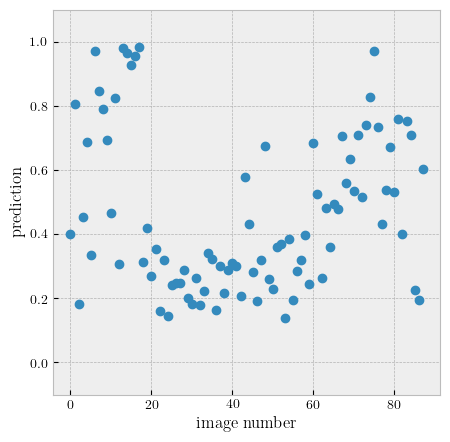

In [17]:
plt.plot(mcp.preds[:-1], 'o')
plt.ylim(-0.1, 1.1)
plt.xlabel('image number')
plt.ylabel('prediction')
# plt.savefig('Lab_preds.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
unripe_eg = cv.imread(x_train[y_train == 0][0])
ripe_eg = cv.imread(x_train[y_train == 1][0])

In [145]:
x = np.linspace(-10, 10, 500)
sigmoid = lambda x: (1 + np.exp(-x))**-1

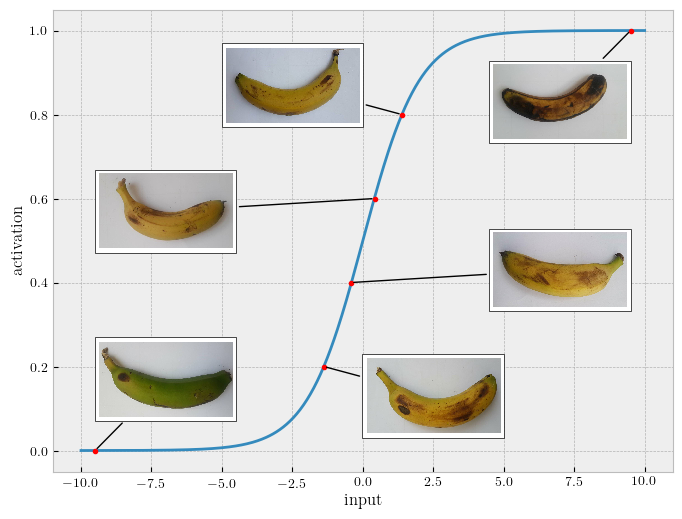

In [166]:
fig, ax = plt.subplots(figsize=(4*2, 3*2))
ax.plot(x, sigmoid(x))
ax.set_xlabel('input')
ax.set_ylabel('activation')

xy = (-9.5, sigmoid(-9.5))
plt.plot(xy[0], xy[1], 'r.')
imagebox = obox.OffsetImage(unripe_eg[:,:,::-1], zoom=0.1)
imagebox.image.axes = ax
ab = obox.AnnotationBbox(imagebox, xy,
                         xybox=(-7.0, 0.17),
                         xycoords='data',
                         boxcoords='data',
                         pad=0.3,
                         arrowprops=dict(arrowstyle='-',
                                         color='k',
                                         linewidth=1,
                                         ))
ax.add_artist(ab)

xy = (9.5, sigmoid(9.5))
plt.plot(xy[0], xy[1], 'r.')
imagebox = obox.OffsetImage(ripe_eg[:,:,::-1], zoom=0.1)
imagebox.image.axes = ax
ab = obox.AnnotationBbox(imagebox, xy,
                         xybox=(7.0, 0.83),
                         xycoords='data',
                         boxcoords='data',
                         pad=0.3,
                         arrowprops=dict(arrowstyle='-',
                                         color='k',
                                         linewidth=1,
                                         ))
ax.add_artist(ab)

pc = 0.20
xy = (x[np.argmin(abs(sigmoid(x) - pc))], pc)
plt.plot(xy[0], xy[1], 'r.')
ripe20percent = cv.imread(midripes[np.argmin(abs(mcp.preds - pc))])
imagebox = obox.OffsetImage(ripe20percent[:,:,::-1], zoom=0.1)
imagebox.image.axes = ax
ab = obox.AnnotationBbox(imagebox, xy,
                         xybox=(2.5, 0.13),
                         xycoords='data',
                         boxcoords='data',
                         pad=0.3,
                         arrowprops=dict(arrowstyle='-',
                                         color='k',
                                         linewidth=1,
                                         ))
ax.add_artist(ab)

pc = 0.40
xy = (x[np.argmin(abs(sigmoid(x) - pc))], pc)
plt.plot(xy[0], xy[1], 'r.')
ripe20percent = cv.imread(midripes[np.argmin(abs(mcp.preds - pc))])
imagebox = obox.OffsetImage(ripe20percent[:,:,::-1], zoom=0.1)
imagebox.image.axes = ax
ab = obox.AnnotationBbox(imagebox, xy,
                         xybox=(7., 0.43),
                         xycoords='data',
                         boxcoords='data',
                         pad=0.3,
                         arrowprops=dict(arrowstyle='-',
                                         color='k',
                                         linewidth=1,
                                         ))
ax.add_artist(ab)

pc = 0.60
xy = (x[np.argmin(abs(sigmoid(x) - pc))], pc)
plt.plot(xy[0], xy[1], 'r.')
ripe20percent = cv.imread(midripes[np.argmin(abs(mcp.preds - pc))])
imagebox = obox.OffsetImage(ripe20percent[:,:,::-1], zoom=0.1)
imagebox.image.axes = ax
ab = obox.AnnotationBbox(imagebox, xy,
                         xybox=(-7., 0.57),
                         xycoords='data',
                         boxcoords='data',
                         pad=0.3,
                         arrowprops=dict(arrowstyle='-',
                                         color='k',
                                         linewidth=1,
                                         ))
ax.add_artist(ab)

pc = 0.80
xy = (x[np.argmin(abs(sigmoid(x) - pc))], pc)
plt.plot(xy[0], xy[1], 'r.')
ripe20percent = cv.imread(midripes[np.argmin(abs(mcp.preds - pc))])
imagebox = obox.OffsetImage(ripe20percent[:,:,::-1], zoom=0.1)
imagebox.image.axes = ax
ab = obox.AnnotationBbox(imagebox, xy,
                         xybox=(-2.5, 0.87),
                         xycoords='data',
                         boxcoords='data',
                         pad=0.3,
                         arrowprops=dict(arrowstyle='-',
                                         color='k',
                                         linewidth=1,
                                         ))
ax.add_artist(ab)

plt.savefig('sigmoid_map.png', dpi=300, bbox_inches='tight')
plt.show()